# PSO Project

The goal of this project is to find an (x,y) pair that optimizes the z coordinate for two famous 3d functions.

1. Eggholder Function
- Domain of [-512, 512]
- Goal of Minimization
- Global minimum at z = -959.6407, at (x,y) = (512, 404.2319)

2. Inverse Drop Wave Function
- Domain of [-5, 5]
- Goal of Maximization
- Global Maximum at z = 6.007
- Imposed restraint of generation of particles in the 4 corners.

In [1]:
#%matplotlib widget
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from copy import deepcopy
import seaborn as sns

In [2]:
def dropwave(x, y): #inverse drop wave [-5, 5] maximize
    return -(-12*x*(np.sin(12*np.sqrt(x**2+y**2)))*(0.5*(x**2+y**2)+2)-x*(1+np.cos(12*np.sqrt(x**2+y**2)))*np.sqrt(x**2+y**2))/((0.5*(x**2+y**2)+2)**2*np.sqrt(x**2+y**2))

In [3]:
def egg(x, y): #eggholder [-512, 512] minimize
    return -(y + 47)* np.sin(np.sqrt(abs(y+x/2+47))) - x*np.sin(np.sqrt(abs(x-(y+47))))

In [4]:
def vizualize(func, domain):
    x = np.linspace(domain[0], domain[1], 50)
    y = np.linspace(domain[0], domain[1], 50)
    X, Y = np.meshgrid(x, y)
    Z = func(X,Y)
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                    cmap='plasma', edgecolor='none')
    ax.set_title('surface');
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    #ax.view_init(20, -90)
    plt.show()

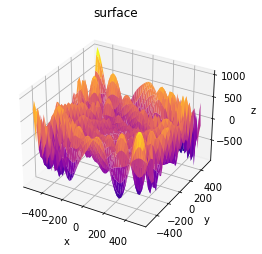

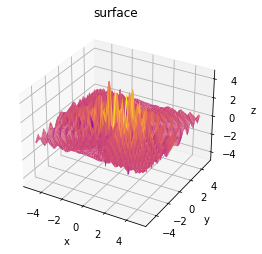

(None, None)

In [5]:
vizualize(egg, [-512, 512]), vizualize(dropwave, [-5, 5])

## PSO

In [6]:
class particle:
    def __init__(self, domain):
        
        if domain == [-5,5]: #drop wave initialization
            canto = random.sample([5, 5, -5, -5], 2) #escolher canto
            self.pos = [] #posição atual da partícula
            
            for i in range(2): 
                if canto[i] > 0:
                    self.pos.append(random.uniform(canto[i] - 0.5, canto[i]))
                else:
                    self.pos.append(random.uniform(canto[i], canto[i] + 0.5))
        
        else: #eggholder initialization
            self.pos = [np.random.normal(0, 3.16), np.random.normal(0, 3.16)]
        
        self.x, self.y = self.pos[0], self.pos[1] 
        self.v = [0, 0] #velocidade atual
        self.fit = 0
        self.optPos = [0, 0] #posição ótima da partícula 
        self.optFit =  0 # fitness da posição ótima
    
    def values(self):
        return self.pos
    
    def velocity_update(self, j, optPosSwarm, w, c, s):
        #fórmula de mudança de velocidade (slides 12/21) j: índice das variáveis do vetor 
        self.v[j] = w*self.v[j] + c*random.uniform(0,1)*(self.optPos[j] - self.pos[j]) + s*random.uniform(0,1)*(optPosSwarm[j] - self.pos[j])
    
    def position_update(self, j, domain):
        self.pos[j] = self.pos[j] + self.v[j]
        if self.pos[j] < domain[0]: # se a nova posição não pertencer ao domínio atribuir o valor do limite
            self.pos[j] = domain[0]
            self.v[j] = - self.v[j] # se uma particula atingir uma parede, inverter direção (velocidade negativa)
        elif self.pos[j] > domain[1]:
            self.pos[j] = domain[1]
            self.v[j] = - self.v[j]

In [7]:
class PSO:
    def __init__(self, func, obj, domain, n_parts, n_iter): 
        self.func = func
        self.obj = obj # objective: "max" if maximization "min" if minimization
        self.domain = domain
        self.n_parts = n_parts #n de partículas
        self.n_iter = n_iter #n de iterações
        self.const = (0.5, 1.8, 2.3) #constantes de inertia/cognitive/social
        self.optPos = (0,0) #melhor posição no Swarm
        self.optFit = 0 # fitness da melhor posição 
        self.swarm = []
        self.sols = []
        
    def evaluate(self, func, x, y):
        return func(x,y)
    
    def visualize(self, swarm, domain):
        plt.figure()
        x = [part.pos[0] for part in swarm]
        y = [part.pos[1] for part in swarm]
        plt.scatter(x,y, alpha = 0.35)
        plt.scatter(*self.optPos, color = "red")
        print(f"std x = {round(np.std(x),5)}, y = {round(np.std(y),5)}")
        plt.show()
    
    def fit(self):
        #criação do swarm // lista de partículas
        self.swarm = [particle(self.domain) for i in range(self.n_parts)]
    
        #Inicialização das variáveis das partículas para não enviesar o resultado
        for part in self.swarm:
            part.optPos = deepcopy(part.pos)
            part.fit = self.evaluate(self.func, *part.optPos)
            part.optFit = self.evaluate(self.func, *part.optPos)
        
        #inicialização das variáveis do PSO (para não serem inicializadas com 0,0 - problemático no drop-wave)
        self.swarm = sorted(self.swarm, key=lambda x: x.fit) 
        self.optPos = self.swarm[-1].pos
        self.optFit = self.evaluate(self.func, *self.optPos)
        
        for i in range(self.n_iter): #Início do loop do algoritmo // correr n_iter vezes
            
            for part in self.swarm: #para cada particula na lista de particulas
                
                for j in range(2): #para cada variável da part/velo (x,y) em que j é o índice da variável
                    part.position_update(j, self.domain) #update da posição da variável j da partícula 
                    part.velocity_update(j, self.optPos, *self.const) #update da velocidade j da particula
                
                #max ou min?
                if self.obj == "max":
                    #a fitness atual da part é a melhor até agora da part?
                    if part.optFit < self.evaluate(self.func, *part.pos): 
                        part.optPos = deepcopy(part.pos)
                        part.optFit = self.evaluate(self.func, *part.pos)
                    
                    #a fitness desta part é a melhor do swarm até agora?
                    if self.optFit < self.evaluate(self.func, *part.pos):
                        self.optPos = deepcopy(part.pos)
                        self.optFit = self.evaluate(self.func, *part.pos)
                else:
                    if part.optFit > self.evaluate(self.func, *part.pos): 
                        part.optPos = deepcopy(part.pos)
                        part.optFit = self.evaluate(self.func, *part.pos)
                       
                    if self.optFit > self.evaluate(self.func, *part.pos):
                        self.optPos = deepcopy(part.pos)
                        self.optFit = self.evaluate(self.func, *part.pos)
                
            self.sols.append(self.optFit)    
            
            if i%49 == 0 or i - 5 < 0 or i == 29 :
                print(f"Epoch {i}: fit: {self.optFit} on {self.optPos}")
                self.visualize(self.swarm, self.domain)
                
        return self
    
    def results(self):
        print("___________________ Results ___________________")
        print(f"\n\tfitness of {round(self.optFit, 5)} on\n\tx = {self.optPos[0]}\n\ty = {round(self.optPos[1], 7)}")
        return self.optFit, self.optPos, self.sols

### Inverse Drop Wave

Foi usada uma quantidade completamente desnecessária de partículas para facilitar a observação do macro comportamento.

Epoch 0: fit: 0.35728365805775747 on [4.503734940800705, -4.516255523371753]
std x = 4.7612, y = 4.73016


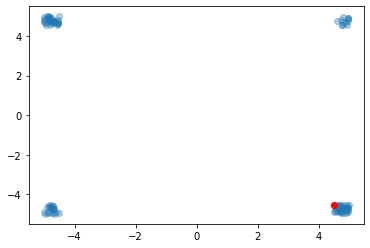

Epoch 1: fit: 0.45531425264748576 on [5, -2.1304970449948737]
std x = 2.33195, y = 2.32472


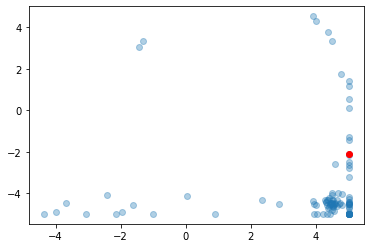

Epoch 2: fit: 1.5051822661783465 on [2.2857339977104987, -0.29369530568121505]
std x = 4.46203, y = 4.19123


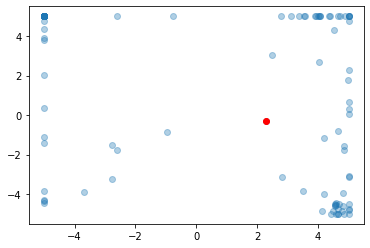

Epoch 3: fit: 1.5051822661783465 on [2.2857339977104987, -0.29369530568121505]
std x = 4.34329, y = 3.0766


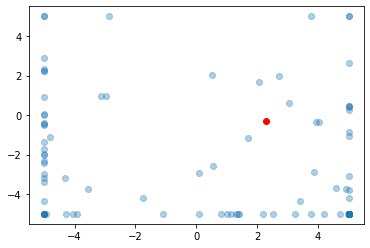

Epoch 4: fit: 1.5051822661783465 on [2.2857339977104987, -0.29369530568121505]
std x = 4.40487, y = 3.72905


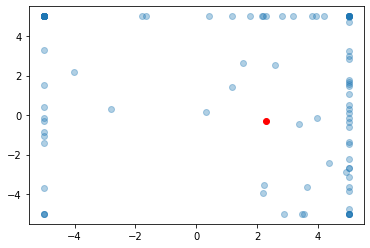

Epoch 29: fit: 4.65589136842514 on [-0.879584122843279, 0.22903536647797962]
std x = 4.53415, y = 3.83254


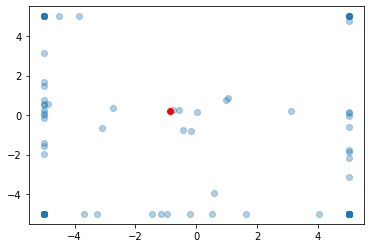

Epoch 49: fit: 5.64747684353424 on [-0.399288086377278, -0.013311829165400257]
std x = 4.63441, y = 3.76595


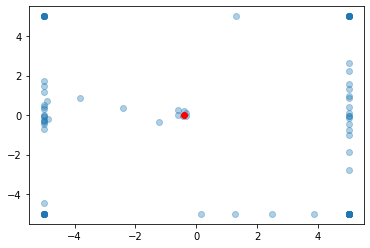

Epoch 98: fit: 6.007016732195192 on [0.13027108341011587, -9.984808195630758e-05]
std x = 4.40971, y = 3.83063


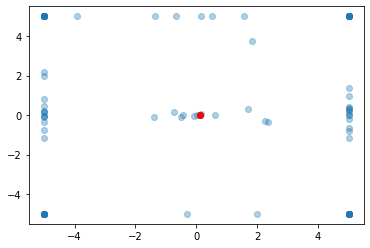

___________________ Results ___________________

	fitness of 6.00702 on
	x = 0.13024889500168546
	y = -8.28e-05


In [8]:
X = PSO(func = dropwave, 
        obj = "max", 
        domain = [-5,5], 
        n_parts = 100, 
        n_iter = 100)

results = X.fit().results()

### Eggholder

Epoch 0: fit: -57.50815843245644 on [1.6625546940893128, 10.395215627470863]
std x = 3.18063, y = 3.21415


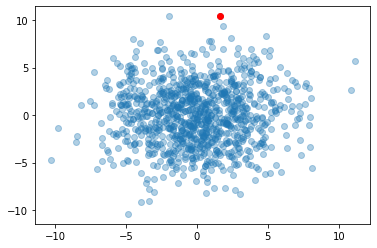

Epoch 1: fit: -66.62341440874039 on [6.957291328879173, 16.61695721623929]
std x = 2.40284, y = 7.26738


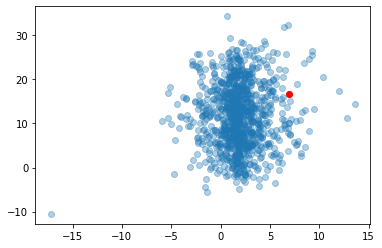

Epoch 2: fit: -66.82868891690906 on [8.590885464423044, 15.321343497683461]
std x = 4.7193, y = 10.13561


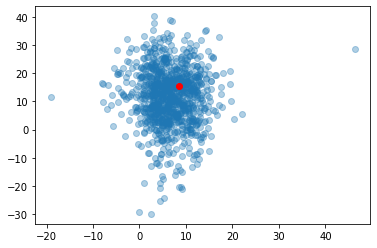

Epoch 3: fit: -66.82868891690906 on [8.590885464423044, 15.321343497683461]
std x = 5.75734, y = 12.77253


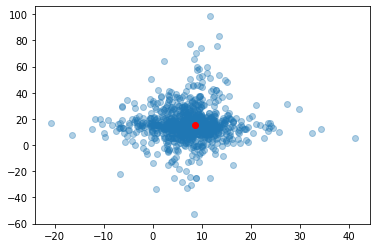

Epoch 4: fit: -107.18729311908668 on [-32.203192360612334, 38.980121292353395]
std x = 7.31304, y = 13.71624


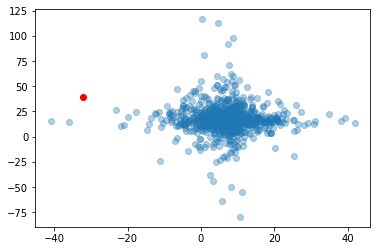

Epoch 29: fit: -959.6406326809645 on [512, 404.23694547917546]
std x = 465.15241, y = 378.86934


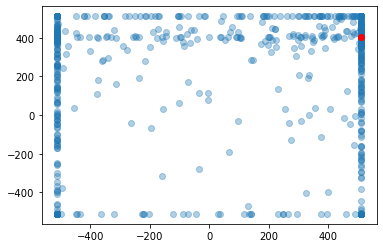

Epoch 49: fit: -959.6406627172922 on [512, 404.2318610621106]
std x = 435.39965, y = 357.13975


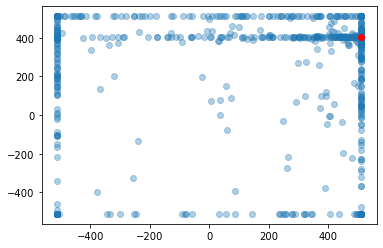

Epoch 98: fit: -959.6406627208509 on [512, 404.2318048409574]
std x = 347.92395, y = 301.98369


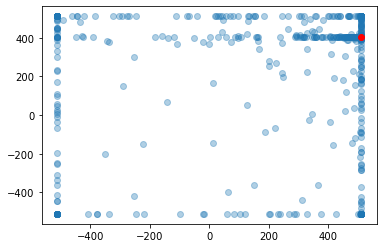

___________________ Results ___________________

	fitness of -959.64066 on
	x = 512
	y = 404.2318048


In [9]:
Y = PSO(func = egg, 
        obj = "min", 
        domain = [-512,512], 
        n_parts = 1000,
        n_iter = 100)

results = Y.fit().results()

Epoch 0: fit: 0.3429809546413253 on [4.55378759629318, 4.567682814671202]
std x = 4.70927, y = 4.77453


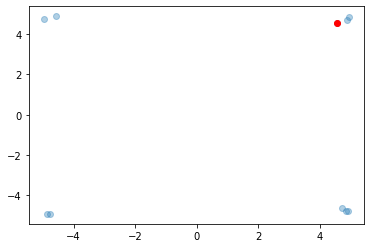

Epoch 1: fit: 0.7988057816121416 on [4.3165573980634955, 2.160285998734472]
std x = 3.40441, y = 2.72728


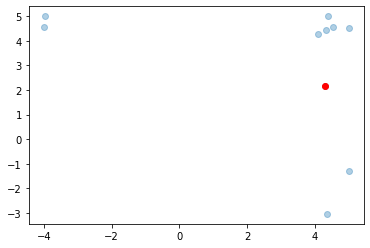

Epoch 2: fit: 0.7988057816121416 on [4.3165573980634955, 2.160285998734472]
std x = 3.87543, y = 4.07408


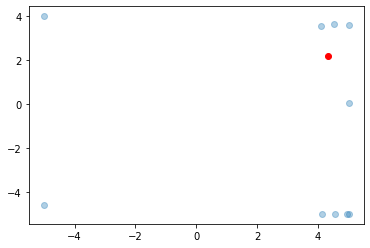

Epoch 3: fit: 0.8712734481886439 on [2.5010797872045236, 2.8698487399583414]
std x = 3.82352, y = 1.57375


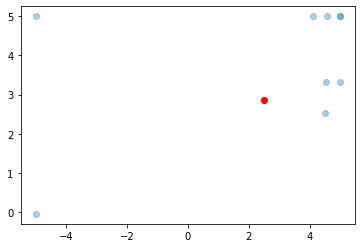

Epoch 4: fit: 0.8712734481886439 on [2.5010797872045236, 2.8698487399583414]
std x = 3.7718, y = 4.07587


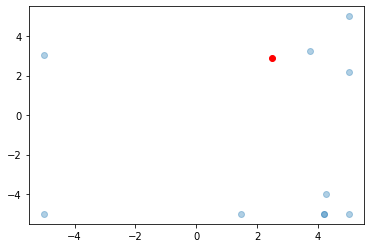

Epoch 29: fit: 3.5115696919057076 on [1.6388067218503717, 0.3900553341712747]
std x = 3.65912, y = 3.84281


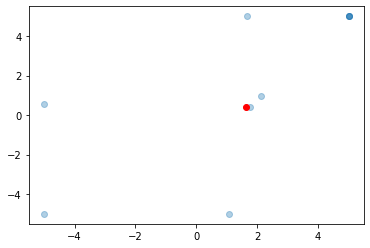

___________________ Results ___________________

	fitness of 3.51157 on
	x = 1.6388067218503717
	y = 0.3900553
Epoch 0: fit: 0.3778632891171619 on [4.500689830810694, 4.5440795814187185]
std x = 4.71594, y = 4.7609


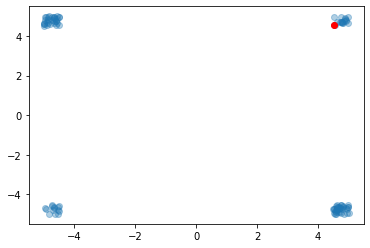

Epoch 1: fit: 1.0906652864604713 on [4.29750159914732, -0.3350883804172877]
std x = 2.48922, y = 2.02719


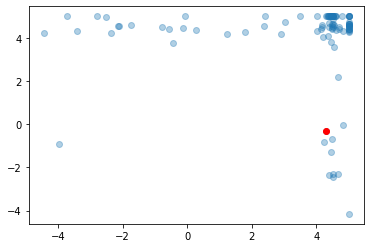

Epoch 2: fit: 1.0906652864604713 on [4.29750159914732, -0.3350883804172877]
std x = 4.0149, y = 3.828


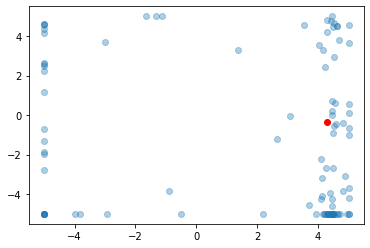

Epoch 3: fit: 1.7322777504156814 on [-2.954196227881976, 0.5830004602101788]
std x = 2.95132, y = 3.48959


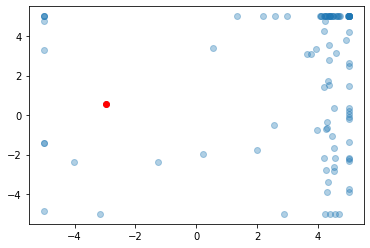

Epoch 4: fit: 1.9953638667690523 on [2.638434604440254, -0.8257869941932054]
std x = 4.4797, y = 3.90783


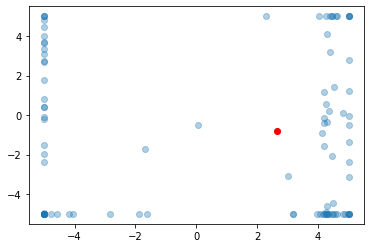

Epoch 29: fit: 4.640900234210324 on [-0.8849915086437994, -0.10677077893401243]
std x = 4.5868, y = 3.89201


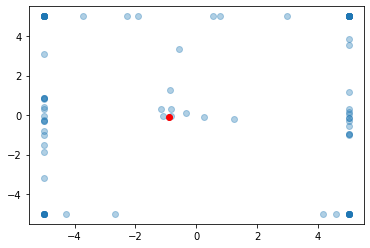

___________________ Results ___________________

	fitness of 4.6409 on
	x = -0.8849915086437994
	y = -0.1067708
Epoch 0: fit: 0.3842576126820579 on [4.5247103180657735, 4.544309483708423]
std x = 4.74792, y = 4.75035


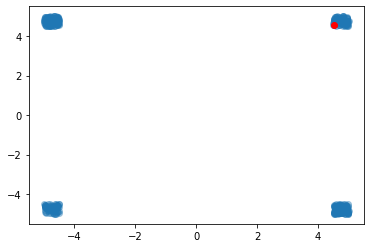

Epoch 1: fit: 1.0509857056273395 on [4.275300117544328, -0.7112172945587742]
std x = 2.22955, y = 2.58342


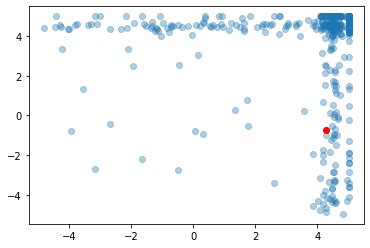

Epoch 2: fit: 1.7950211627084258 on [-0.18345420445830696, 0.40776508487972585]
std x = 4.14152, y = 3.12884


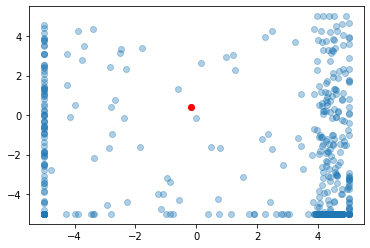

Epoch 3: fit: 4.658399692885411 on [0.641291519238909, -0.25098301935596457]
std x = 3.89186, y = 3.04476


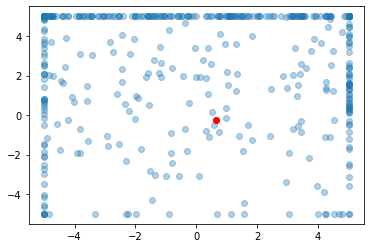

Epoch 4: fit: 4.658399692885411 on [0.641291519238909, -0.25098301935596457]
std x = 3.92843, y = 3.47617


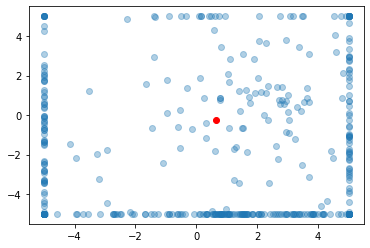

Epoch 29: fit: 6.001268267819151 on [0.13289107391152713, -0.0039586122263226865]
std x = 4.37862, y = 3.86837


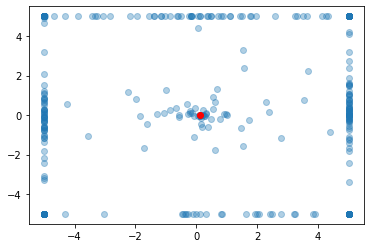

___________________ Results ___________________

	fitness of 6.00127 on
	x = 0.13289107391152713
	y = -0.0039586


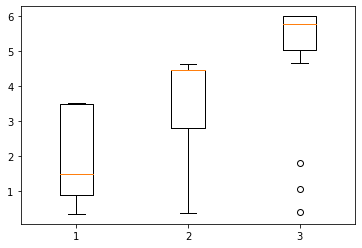

In [11]:
A = PSO(func = dropwave, 
        obj = "max", 
        domain = [-5,5], 
        n_parts = 10, 
        n_iter = 30)

B = PSO(func = dropwave, 
        obj = "max", 
        domain = [-5,5], 
        n_parts = 100, 
        n_iter = 30)

C = PSO(func = dropwave, 
        obj = "max", 
        domain = [-5,5], 
        n_parts = 500, 
        n_iter = 30)

def box(lst):
    data = [pso.fit().results()[2] for pso in lst]
    plt.boxplot(data, )
    
box([A,B,C])